In [21]:
import numpy as np
from mayavi import mlab
import trimesh

from bfieldtools.coil_optimize import optimize_streamfunctions
from bfieldtools.mesh_conductor import MeshConductor

from bfieldtools.viz import plot_data_on_vertices
from bfieldtools import sphtools

In [2]:
mlab.init_notebook('png')

Notebook initialized with png backend.


In [78]:
coil_mesh = trimesh.load("cylinder_reg_HR_70x120.stl")
# coil_mesh.apply_scale(10)
coil = MeshConductor(mesh_obj=coil_mesh, fix_normals=True,basis_name='suh', N_suh=100)

# shield_mesh = trimesh.load("cylinder_LR.stl")
# shield_mesh.apply_scale(1.1)

# shield = MeshConductor(mesh_obj=shield_mesh, process=True, fix_normals=True, basis_name="vertex")

Calculating surface harmonics expansion...
Computing the laplacian matrix...
Computing the mass matrix...


In [79]:
sidelength = 40
n = 20
xx = np.linspace(-sidelength / 2, sidelength / 2, n)
yy = np.linspace(-sidelength / 2, sidelength / 2, n)
zz = np.linspace(-sidelength / 2, sidelength / 2, n)
X, Y, Z = np.meshgrid(xx, yy, zz, indexing="ij")

x = X.ravel()
y = Y.ravel()
z = Z.ravel()

target_points = np.array([x, y, z]).T

# Turn cube into sphere by rejecting points "in the corners"
target_points = (
    target_points[np.linalg.norm(target_points, axis=1) < sidelength / 2]
)


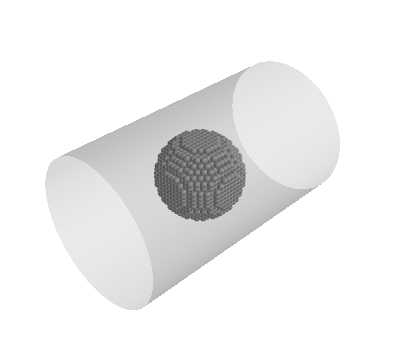

In [80]:
f = mlab.figure(bgcolor=(1, 1, 1), fgcolor=(.5, .5, .5))
mlab.points3d(*target_points.T)
coil.plot_mesh(opacity=0.2, figure=f)
# shield.plot_mesh(opacity=0.2, figure=f)


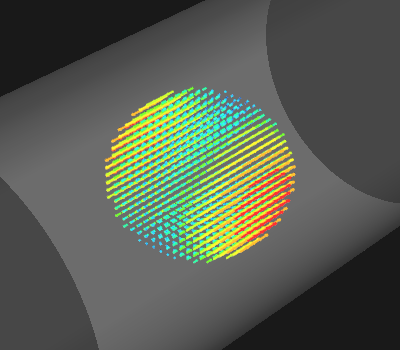

In [81]:
lmax = 2
alm = np.zeros((lmax * (lmax + 2),))
blm = np.zeros((lmax * (lmax + 2),))

# Set one specific component to one
blm[7] += 1


sphfield = sphtools.field(target_points, alm, blm, lmax)
target_field = sphfield / np.max(sphfield[:, 0])

field_y = target_field.copy()

field_y[:, 2] = 0
field_y[:, 1] = 0

mlab.clf()
f = mlab.figure(bgcolor=(.1, .1, .1), fgcolor=(1, 1, 1))
mlab.quiver3d(*target_points.T, *field_y.T, figure=f)
coil.plot_mesh(opacity=0.2, figure=f)
f.scene.isometric_view()
f.scene.camera.zoom(2)

# mlab.view(90, 180)
f

In [82]:
import mosek


target_spec = {
    "coupling": coil.B_coupling(target_points),
    "abs_error": 0.1,
    "target": target_field,
}

coil.s, prob = optimize_streamfunctions(
    coil,
    [target_spec],
    objective="minimum_inductive_energy",
    solver="MOSEK",
    solver_opts={"mosek_params": {mosek.iparam.num_threads: 8}},
)

Computing magnetic field coupling matrix, 5202 vertices by 3544 target points... took 8.82 seconds.
Computing the inductance matrix...
Computing self-inductance matrix using rough quadrature (degree=2).              For higher accuracy, set quad_degree to 4 or more.
Estimating 81344 MiB required for 5202 by 5202 vertices...
Computing inductance matrix in 240 chunks (7047 MiB memory free),              when approx_far=True using more chunks is faster...
Computing triangle-coupling matrix
Inductance matrix computation took 67.54 seconds.
Passing problem to solver...
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Oct 08 07:39:53 PM: Your problem has 100 variables, 2 constraints, and 0 parameters.
(CVXPY) Oct 08 07:39:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 08 07:39:53 PM: (If you need to solve this problem multiple times, but with diffe

Processing contour, value: -89544969.82003401
Processing contour, value: -79010262.59486203
Processing contour, value: -68475555.36969005
Processing contour, value: -57940848.14451806
Processing contour, value: -47406140.91934608
Processing contour, value: -36871433.694174096
Processing contour, value: -26336726.469002113
Processing contour, value: -15802019.24383013
Processing contour, value: -5267312.018658146
Processing contour, value: 5267395.206513837
Processing contour, value: 15802102.43168582
Processing contour, value: 26336809.656857803
Processing contour, value: 36871516.88202979
Processing contour, value: 47406224.10720177
Processing contour, value: 57940931.33237375
Processing contour, value: 68475638.55754574
Processing contour, value: 79010345.78271772
Processing contour, value: 89545053.0078897



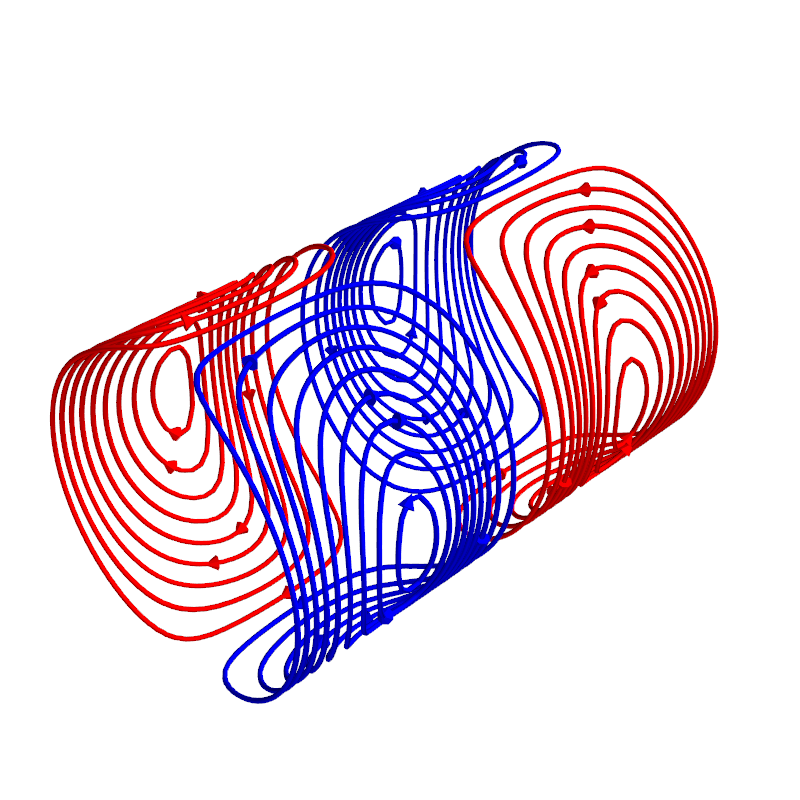

In [85]:
loops = coil.s.discretize(N_contours=18)


# coil.s.plot(ncolors=256)
loops.plot_loops()

In [91]:
loops_dict = loops.to_dict()

paths = loops_dict['entities']
vertices = loops_dict['vertices']

vertices_cyl = []

radius = 35
L = 120

for v in vertices: # X axis cilynder
    x, y, z = v
    theta = np.arctan2(y, z)

    l = theta*radius
    vertices_cyl.append((l, x, 0))

path = []
for p in paths:
    line = p['points']
    for i in range(len(line)):
        if i == len(line)-1:
            path.append((line[i], line[0]))
        else:
            path.append((line[i], line[i+1]))



In [92]:
def spline_length(spl, closed=False):
    u = np.linspace(0, 1, 100)
    I = 0
    add_cl = 0 if closed else 0
    for i in range(len(u)-add_cl):
        if closed and i == len(u)-1:
            I += np.linalg.norm(np.array(splev(u[i], spl)) - np.array(splev(u[0], spl)))
        else:
            I += np.linalg.norm(np.array(splev(u[i+1], spl)) - np.array(splev(u[i], spl)))
    
    return I



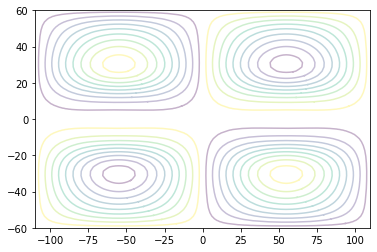

In [93]:
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.interpolate import splprep, splev

col = plt.cm.viridis(np.linspace(0, 1, int(len(paths)/4)))

tl = []
tr = []
bl = []
br = []

for j in range(int(len(paths)/4)):
    span = int(len(paths)/2)
    line = np.array([list(vertices_cyl[i])[:2] for i in paths[j*2]['points']])
    tl.append(line)
    plt.plot(*line.T, alpha=0.3, color=col[j])
    line = np.array([list(vertices_cyl[i])[:2] for i in paths[j*2+span]['points']])
    tr.append(line)
    plt.plot(*line.T, alpha=0.3, color=col[j])
    line = np.array([list(vertices_cyl[i])[:2] for i in paths[j*2+1]['points']])
    bl.append(line)
    plt.plot(*line.T, alpha=0.3, color=col[j])
    line = np.array([list(vertices_cyl[i])[:2] for i in paths[j*2+1+span]['points']])
    br.append(line)

    plt.plot(*line.T, alpha=0.3, color=col[j])

plt.xlim([-np.pi*radius, np.pi*radius])
plt.ylim([-L/2, L/2])
plt.show()



## Refactor contours with equally spaced points

In [99]:
new_vertices = []
new_edges = []
tot_len = 0
index = 0

res = 1
closed = True
for line in tl+tr+br+bl:
    spl, _ = splprep(line.T, s=0)
    l = spline_length(spl, True)
    tot_len+=l
    points = np.linspace(0, 1, int(l/res))

    for i, p in enumerate(points):
        
        vert = tuple(list(np.array(splev(p, spl)))+[0])
        new_vertices.append(vert)
        
        if i > 0:
            new_edges.append((index-1, index))
        index+=1

print(new_edges[-1])
print(tot_len)
plt.show()

(6110, 6111)
6129.400283834194


In [100]:
new_vertices = np.array(new_vertices)
new_edges = np.array(new_edges, dtype=np.int32)

with open('vertices.txt', 'w') as f:
   np.savetxt(f, new_vertices)

with open('edges.txt', 'w') as f:
   np.savetxt(f, new_edges)